In [4]:
import sys, os
import torch
import numpy as np
import torch.nn.functional as F
import torch.optim as opt
import pandas as pd
from torch.nn import Module, Parameter
from torch import softmax, log_softmax, Tensor
from torch_sparse import SparseTensor
from sklearn.cluster import KMeans
import scipy.sparse as sp
from scipy.sparse.linalg import svds
import time
from umap import UMAP
import matplotlib.pyplot as plt
from scipy.sparse import load_npz
from sklearn.decomposition import PCA
import utils

In [5]:
class NewModel(Module):
    def __init__(self, dir, N=3, batch_size=1.0, interval=10, lr=1e-3, init='svd'):
        super().__init__()
        self.batch_size = batch_size
        self.interval = interval
        self.alpha = torch.FloatTensor([1, 1, 1, 1, 1, 1])
        # data
        counts_rna = sp.load_npz(os.path.join(dir, 'C1xG.npz'))
        counts_atac = sp.load_npz(os.path.join(dir, 'C2xR.npz')).astype(np.float32)
        A = sp.load_npz(os.path.join(dir, 'GxR.npz')).tocoo()

        self.G = torch.FloatTensor(counts_rna.todense())
        self.R = torch.FloatTensor(counts_atac.todense())
        self.A = torch.FloatTensor(A.todense())

        self.s_g = Parameter(torch.ones(1, self.G.shape[1]))
        self.s_r = Parameter(torch.ones(1, self.R.shape[1]))
        self.b_g = Parameter(torch.zeros(1, self.G.shape[1]))
        self.b_r = Parameter(torch.zeros(1, self.R.shape[1]))
        self.C_1 = Parameter(torch.randn(self.G.shape[0], N))
        self.C_2 = Parameter(torch.randn(self.R.shape[0], N))
        self.C_g = Parameter(torch.randn(self.G.shape[1], N))
        self.C_r = Parameter(torch.randn(self.R.shape[1], N))

        self.meta_rna = pd.read_csv(os.path.join(dir, "meta_rna.csv"), index_col=0)
        self.meta_atac = pd.read_csv(os.path.join(dir, "meta_atac.csv"), index_col=0)
        self.regions = pd.read_csv(os.path.join(dir, "regions.txt"), header=None)
        self.genes = pd.read_csv(os.path.join(dir, "genes.txt"), header=None)

        self.optimizer = opt.Adam(self.parameters(), lr=lr)

        # with torch.no_grad():
        #     loss, *_ = self.batch_loss('valid')
        #     print('Initial Loss is {:.5f}'.format(loss.item()))

    @staticmethod
    def softmax(X: Tensor):
        return torch.softmax(X, dim=1)

    @staticmethod
    def entropy_loss(C):
        loss = - F.softmax(C, dim=1) * F.log_softmax(C, dim=1)
        return loss.sum(dim=1).mean()

    def batch_loss(self, mode='C_c'):
        if mode != 'valid':
            mask_1 = np.random.choice(self.G.shape[0], int(self.G.shape[0] * self.batch_size), replace=False)
            mask_2 = np.random.choice(self.R.shape[0], int(self.R.shape[0] * self.batch_size), replace=False)
            mask_g = np.random.choice(self.G.shape[1], int(self.G.shape[1] * self.batch_size), replace=False)
            mask_r = np.random.choice(self.R.shape[1], int(self.R.shape[1] * self.batch_size), replace=False)
        if mode == 'C_12':
            loss1 = (self.G[np.ix_(mask_1, mask_g)] - self.s_g[:, mask_g] * (self.softmax(self.C_1[mask_1]) @
                     self.softmax(self.C_g[mask_g].detach()).t()) - self.b_g[:, mask_g]).pow(2).mean()
            loss2 = (self.R[np.ix_(mask_2, mask_r)] - self.s_r[:, mask_r] * (self.softmax(self.C_2[mask_2]) @
                     self.softmax(self.C_r[mask_r].detach()).t()) - self.b_r[:, mask_r]).pow(2).mean()
            loss3, loss4 = 0, 0
        elif mode == 'C_gr':
            loss1 = (self.G[np.ix_(mask_1, mask_g)] - self.s_g[:, mask_g] * (self.softmax(self.C_1[mask_1].detach()) @
                     self.softmax(self.C_g[mask_g]).t()) - self.b_g[:, mask_g]).pow(2).mean()
            loss2 = (self.R[np.ix_(mask_2, mask_r)] - self.s_r[:, mask_r] * (self.softmax(self.C_2[mask_2].detach()) @
                     self.softmax(self.C_r[mask_r]).t()) - self.b_r[:, mask_r]).pow(2).mean()
            loss3 = (self.A[mask_g] @ self.C_r - self.C_g[mask_g]).pow(2).mean()
            loss4 = self.entropy_loss(self.C_g[mask_g]) + self.entropy_loss(self.C_r[mask_g])
        elif mode == 'valid':
            with torch.no_grad():
                loss1 = (self.G - self.s_g * (self.softmax(self.C_1) @
                         self.softmax(self.C_g).t()) - self.b_g).pow(2).mean()
                loss2 = (self.R - self.s_r * (self.softmax(self.C_2.detach()) @
                         self.softmax(self.C_r).t()) - self.b_r).pow(2).mean()
                loss3 = (self.A @ self.C_r - self.C_g).pow(2).mean()
                loss4 = self.entropy_loss(self.C_g) + self.entropy_loss(self.C_r)
        else:
            raise NotImplementedError
        loss = self.alpha[0] * loss1 + self.alpha[1] * loss2 + self.alpha[2] * loss3 + self.alpha[3] * loss4

        return loss, self.alpha[0] * loss1, self.alpha[1] * loss2, self.alpha[2] * loss3, self.alpha[3] * loss4
    #
    def train_func(self, T):
        best_loss = 1e12
        count = 0
        for t in range(T):
            self.optimizer.zero_grad()
            # for mode in ['C_c']:
            for mode in ['C_12', 'C_gr', 'C_12', 'C_gr']:
                loss, *_ = self.batch_loss(mode)
                loss.backward()
                self.optimizer.step()
            if (t+1) % self.interval == 0:
                loss, loss1, loss2, loss3, loss4 = self.batch_loss('valid')
                print('Epoch {}, Training Loss: {:.4f}'.format(t + 1, loss.item()))
                info = [
                    'loss RNA: {:.5f}'.format(loss1.item()),
                    'loss ATAC: {:.5f}'.format(loss2.item()),
                    'loss gene act: {:.5f}'.format(loss3.item()),
                    'loss sparse: {:.5f}'.format(loss4.item()),
                ]
                for i in info:
                    print("\t", i)
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(self.state_dict(), '../check_points/real.pt')
                count = 0
            else:
                count += 1
                if count % 20 == 0:
                    self.optimizer.param_groups[0]['lr'] *= 0.5
                    print('Epoch: {}, shrink lr to {:.4f}'.format(t + 1, self.optimizer.param_groups[0]['lr']))
                    if self.optimizer.param_groups[0]['lr'] < 1e-4:
                        break
                    else:
                        self.load_state_dict(torch.load('../check_points/real.pt'))
                        count = 0

In [15]:
model = NewModel(dir = '../data/real/BMMC/', N=24, lr=1e-3, interval=1, batch_size=0.2)
model.load_state_dict(torch.load('../check_points/real_24.pt'))

<All keys matched successfully>

None
None


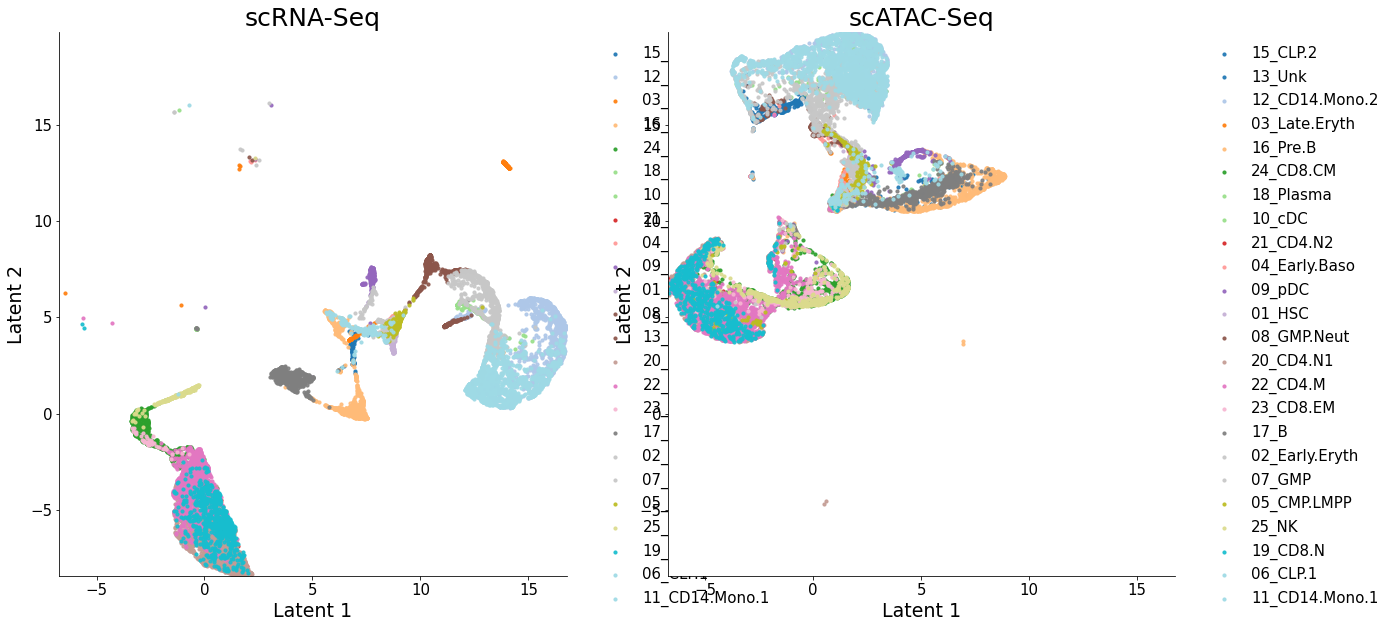

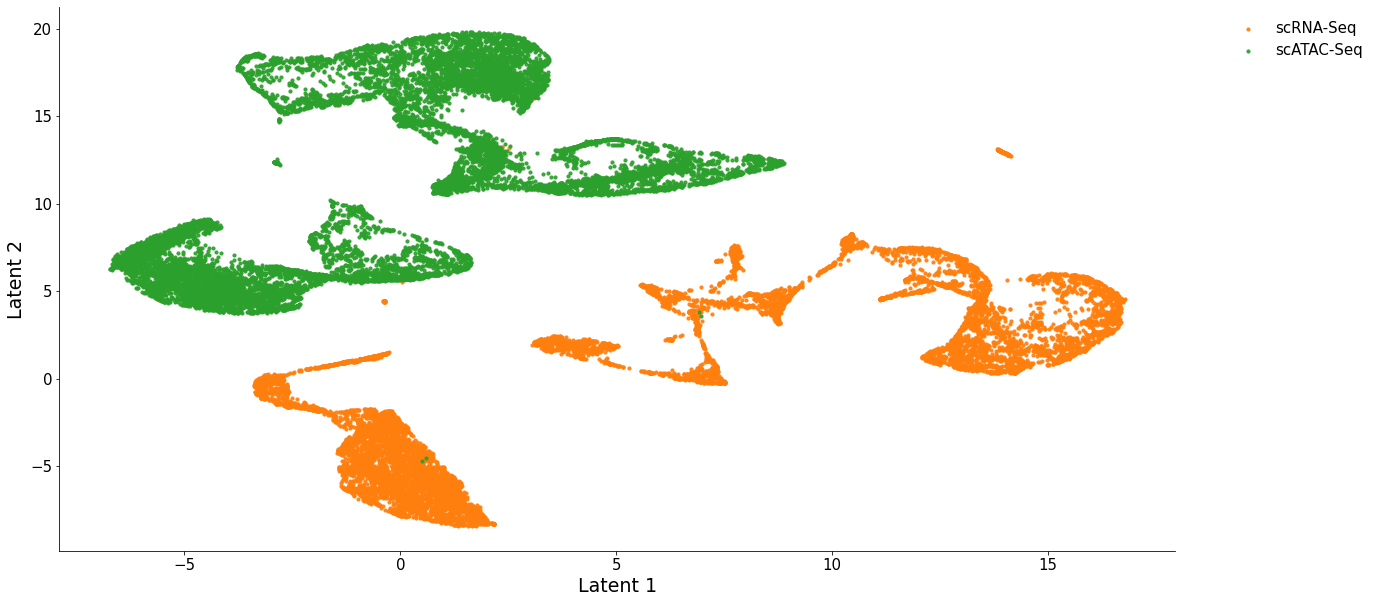

In [21]:
z_rna = torch.softmax(model.C_1.detach(), dim=1).numpy()
z_atac = torch.softmax(model.C_2.detach(), dim=1).numpy()
umap_op = UMAP(n_components = 2)
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = model.meta_rna["cluster"].values
label_atac = model.meta_atac["cluster"].values
# label_rna = model.label_c1.numpy()[:,None]
# label_atac = model.label_c2.numpy()[:,None]

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "modality", save = None)

In [20]:
# z_rna = torch.softmax(model.C_1.detach(), dim=1).numpy()
# z_atac = torch.softmax(model.C_2.detach(), dim=1).numpy()
print(z_rna[13:16])

[[9.0069128e-03 7.6828795e-03 5.4958540e-01 2.4837008e-01 1.2922347e-04
  8.8473520e-04 4.9369349e-03 2.5651029e-03 2.6556691e-03 7.4472944e-03
  8.2800843e-02 4.5379577e-03 4.3932628e-03 4.8361639e-03 2.4883009e-02
  1.2670430e-02 2.2869480e-04 1.1448974e-03 4.0696459e-03 1.4180995e-03
  1.8535078e-02 3.7529145e-03 9.6434215e-04 2.5003974e-03]
 [3.9543547e-03 9.8074805e-03 5.3076339e-01 2.7671239e-01 5.2140518e-03
  3.3373124e-04 1.4490612e-03 9.7662734e-04 4.4570849e-03 1.1937735e-03
  8.4397700e-03 2.7509341e-02 1.8311581e-03 6.1006160e-03 1.4699034e-02
  3.0793432e-02 7.5084777e-03 1.0510959e-03 5.0913668e-03 4.0810956e-03
  2.3580873e-02 1.2339311e-02 6.8727029e-03 1.5239798e-02]
 [1.6157009e-03 9.5564751e-03 6.7937976e-01 1.0167505e-01 3.6613925e-04
  2.0965820e-03 7.3866933e-03 4.9771792e-03 2.5920472e-03 2.0021109e-03
  3.5477623e-02 1.0001704e-03 1.5455815e-02 7.3243538e-03 6.3196950e-02
  3.3384317e-03 7.0077676e-04 4.9384651e-03 6.9704358e-03 1.1243937e-02
  1.4381292e-02 1.

None
None


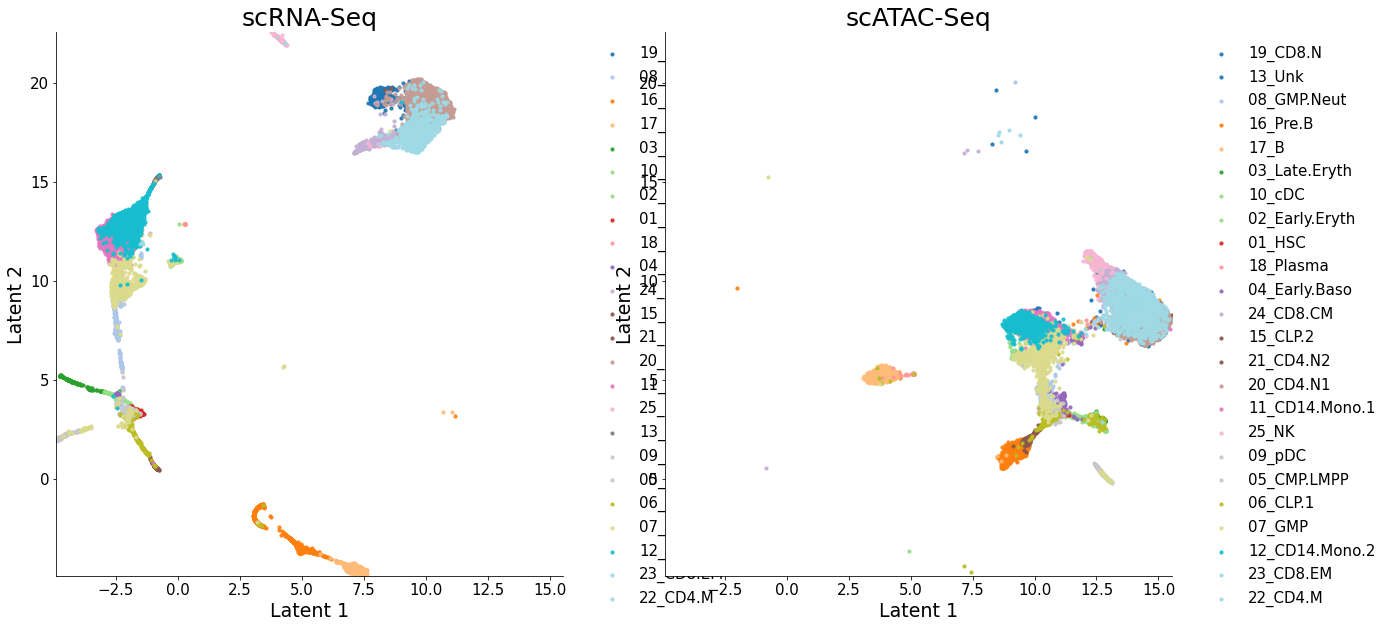

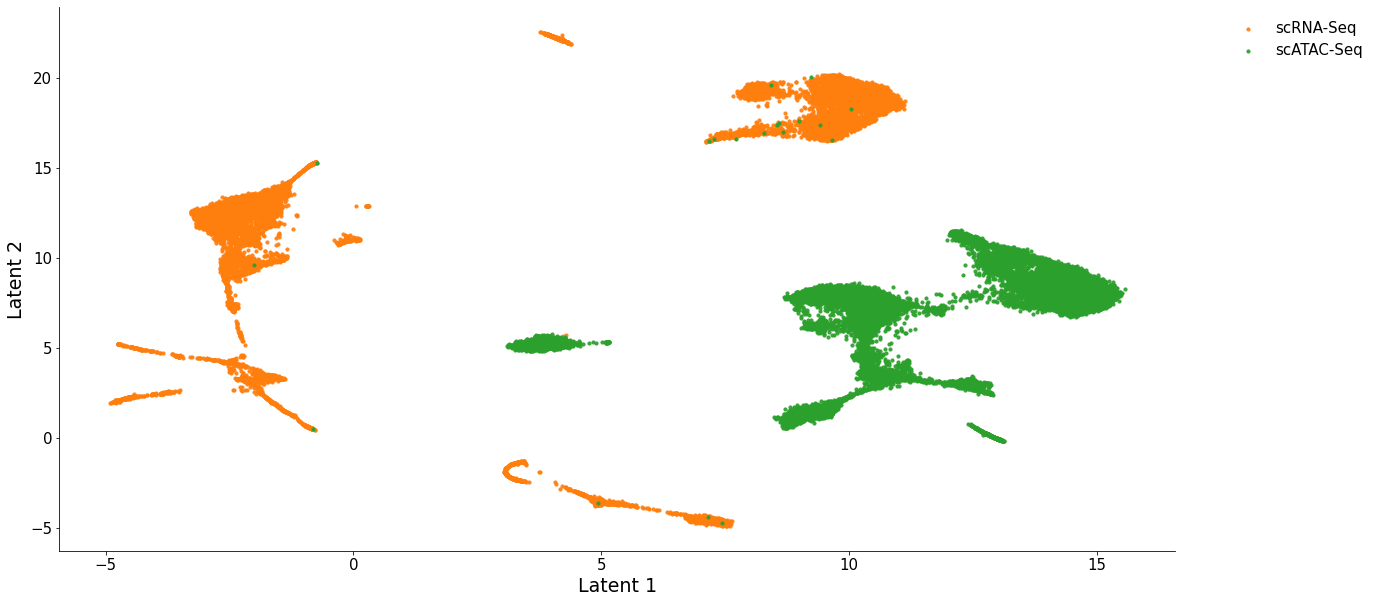

In [32]:
# baseline

from scipy.sparse.linalg import svds
z_rna = load_npz("../data/real/BMMC/C1xG.npz")
z_rna, *_ = svds(z_rna, k=25)
z_atac = load_npz("../data/real/BMMC/C2xR.npz").astype(np.float32)
z_atac, *_ = svds(z_atac, k=25)
umap_op = UMAP(n_components = 2)
z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]
# z_rna = model.C_1.detach().numpy()
# z_atac = model.C_2.detach().numpy()
# umap_op = UMAP(n_components = 2)
# z = umap_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
# z_rna = z[:z_rna.shape[0],:]
# z_atac = z[z_rna.shape[0]:,:]

label_rna = model.meta_rna["cluster"].values
label_atac = model.meta_atac["cluster"].values
# label_rna = model.label_c1.numpy()[:,None]
# label_atac = model.label_c2.numpy()[:,None]

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "modality", save = None)

None
None


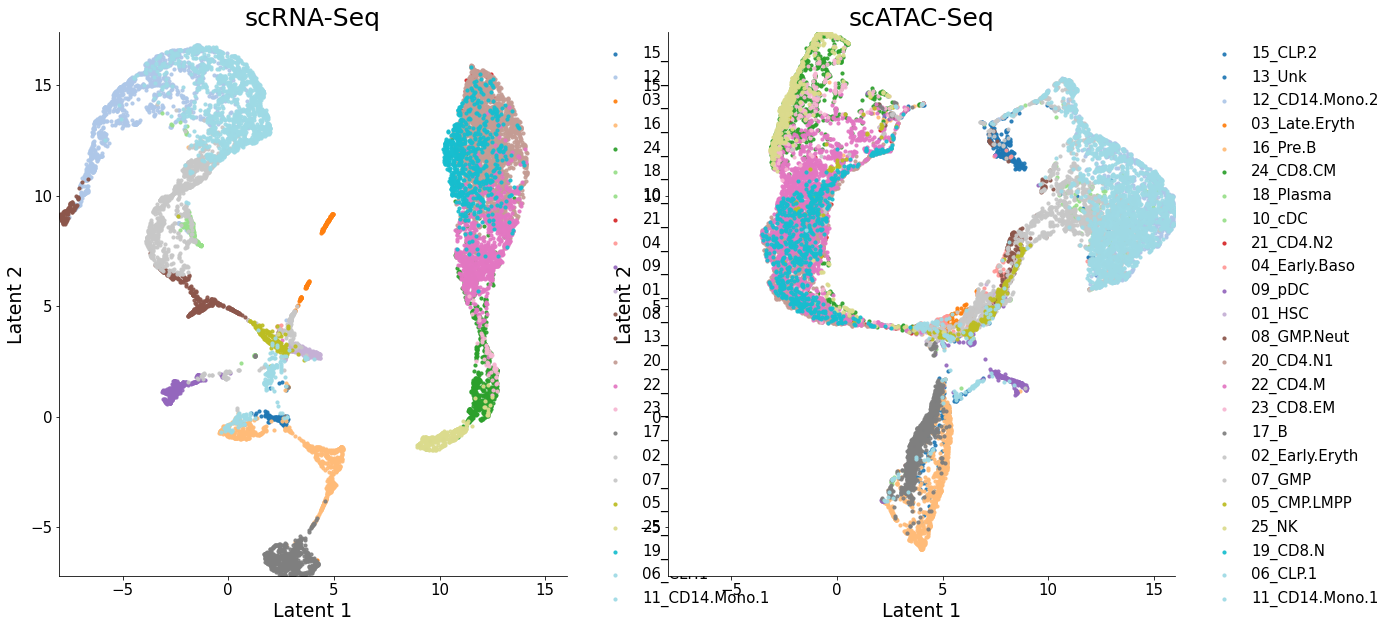

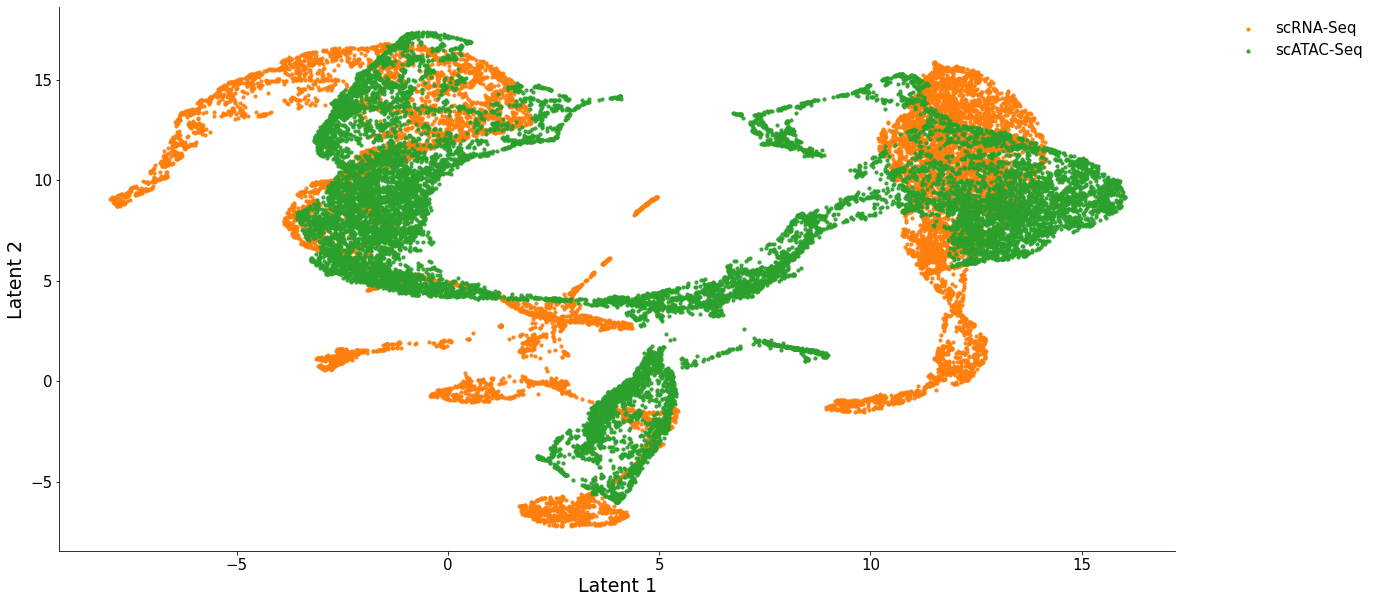

In [23]:
model = NewModel(dir = '../data/real/BMMC/', N=24, lr=1e-3, interval=1, batch_size=0.2)
model.load_state_dict(torch.load('../check_points/real_24.pt'))
z_rna = torch.softmax(model.C_1.detach(), dim=1).numpy()
z_atac = torch.softmax(model.C_2.detach(), dim=1).numpy()
umap_op = UMAP(n_components = 2)
z_rna = umap_op.fit_transform(z_rna)
z_atac = umap_op.fit_transform(z_atac)
label_rna = model.meta_rna["cluster"].values
label_atac = model.meta_atac["cluster"].values
# label_rna = model.label_c1.numpy()[:,None]
# label_atac = model.label_c2.numpy()[:,None]

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "modality", save = None)